In [1]:
import preprocessor
import demoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Load your dataset with columns 'tweet' and 'categories'
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
dataset['label'] = dataset['label'].map({0: 1, 1: 0}) # swap label 0 to label 1 and vice versa
print(dataset.columns)
print(dataset.shape)
print(dataset.head(10))

Index(['label', 'tweet', 'label_category'], dtype='object')
(24783, 3)
   label                                              tweet  \
0      2  !!! rt @mayasolovely: as a woman you shouldn't...   
1      1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...   
2      1  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...   
3      1  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...   
4      1  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...   
5      1  !!!!!!!!!!!!!!!!!!"@t_madison_x: the shit just...   
6      1  !!!!!!"@__brighterdays: i can not just sit up ...   
7      1  !!!!“@selfiequeenbri: cause i'm tired of you b...   
8      1  " & you might not get ya bitch back & thats th...   
9      1  " @rhythmixx_ :hobbies include: fighting maria...   

       label_category  
0             Neutral  
1  Offensive Language  
2  Offensive Language  
3  Offensive Language  
4  Offensive Language  
5  Offensive Language  
6  Offensive Language  
7  Offensive Language  
8  Offensive Langua

In [4]:
# Load and preprocess your dataset
def preprocess_text(text):
    # Use tweet-preprocessor to clean tweets
    cleaned_text = preprocessor.clean(text)
    # Remove emojis
    cleaned_text = remove_emojis(cleaned_text)
    return cleaned_text

def remove_emojis(text):
    return demoji.replace(text, '')

# Preprocess text
dataset['cleaned_tweet'] = dataset['tweet'].apply(preprocess_text)

print(dataset.columns)
print(dataset.shape)
# print(dataset.head(10))

Index(['label', 'tweet', 'label_category', 'cleaned_tweet'], dtype='object')
(20620, 4)


In [5]:
# Split the dataset into training and testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(
    dataset['cleaned_tweet'],  # Features
    dataset['label'],  # Labels
    test_size=0.4, 
    random_state=42
)

# Split the testing set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp,
    y_test_temp,
    test_size=0.5,
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Print the sizes of each set: Training 60% / Val 20% / Testing 20% 
print("Training set size:", len(X_train), "(Hate Speech: ", sum(y_train == 1), ", Offensive Language: ", sum(y_train == 0), ")")
print("Validation set size:", len(X_val), "(Hate Speech: ", sum(y_val == 1), ", Offensive Language: ", sum(y_val == 0), ")")
print("Testing set size:", len(X_test), "(Hate Speech: ", sum(y_test == 1), ", Offensive Language: ", sum(y_test == 0), ")")

Training set size: 12372 (Hate Speech:  886 , Non-Hate Speech:  11486 )
Validation set size: 4124 (Hate Speech:  262 , Non-Hate Speech:  3862 )
Testing set size: 4124 (Hate Speech:  282 , Non-Hate Speech:  3842 )


In [6]:
# print type for train, val, and test, also the shape
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_val), X_val.shape)
print(type(y_val), y_val.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)
print(X_train.head(10))
print(y_train.head(10))

<class 'pandas.core.series.Series'> (12372,)
<class 'pandas.core.series.Series'> (12372,)
<class 'pandas.core.series.Series'> (4124,)
<class 'pandas.core.series.Series'> (4124,)
<class 'pandas.core.series.Series'> (4124,)
<class 'pandas.core.series.Series'> (4124,)
0    i knw these bitch niggas frm way back... if u ...
1    and its people like you that give us all a bad...
2    i ain't got time for a hoe tell her hop in the...
3                         why bitches gotta be bitches
4                     i was lit den a bitch last night
5    rt kanye is best when a good piece of pussy fu...
6                               " bitch plz whatever "
7    some thots will just never learn gooooo awaaaa...
8                                 and little bitch ass
9                                 some fucking bitches
Name: cleaned_tweet, dtype: object
0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit TF-IDF vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTEENN to balance the dataset
smote_enn = SMOTEENN(sampling_strategy=0.5, random_state=42)
X_train_smote_enn, y_train_resampled = smote_enn.fit_resample(X_train_tfidf, y_train)

# Print the sizes of resampled training set
print("Resampled Training set size:", X_train_smote_enn.shape[0], "(Hate Speech: ", sum(y_train_resampled == 1), ", Offensive Language: ", sum(y_train_resampled == 0), ")")


Resampled Training set size: 6375 (Hate Speech:  5603 , Non-Hate Speech:  772 )


In [14]:
# Convert TF-IDF transformed data back to text
X_train_resampled_text = tfidf_vectorizer.inverse_transform(X_train_smote_enn)

# Concatenate the tokens to form sentences
X_train_resampled_text = [' '.join(tokens) for tokens in X_train_resampled_text]

# Convert the list of tokenized sentences back into a Series
X_train_resampled = pd.Series(X_train_resampled_text, name='X_train_resampled')

# Tokenize the balanced training data using BERTweet
tokenized_resampled_train = pd.DataFrame({'tweet': X_train_resampled, 'label': y_train_resampled})

print(tokenized_resampled_train.head(10))

                                            tweet  label
0                                lol re you bitch      0
1                                  this out bitch      0
2                  httpurl close another up pussy      0
3  off playin cut thought when that you was bitch      0
4                                 lmao this bitch      0
5                           main my httpurl bitch      0
6                                       niggah my      0
7           need nigga money fuck rt is all bitch      0
8                              too love you bitch      0
9                                      um bye hoe      0


In [15]:
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
# Tokenize and prepare input data for training set
tokenized_train = X_train_resampled.apply(tokenize_data)
print("Training set size: ", len(tokenized_train))
print(tokenized_train.head(3))
tokenized_val = X_val.apply(tokenize_data)
print("Validation set size: ", len(tokenized_val))
print(tokenized_val.head(3))
tokenized_test = X_test.apply(tokenize_data)
print("Testing set size: ", len(tokenized_test))
print(tokenized_test.head(3))

Training set size:  6375
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: X_train_resampled, dtype: object
Validation set size:  4124
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object
Testing set size:  4124
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object


In [16]:
# Create DataLoader for training set
input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train_resampled.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

# Create DataLoader for validation set
input_ids_val = torch.cat([tokenized_val[i]['input_ids'] for i in range(len(tokenized_val))], dim=0)
attention_masks_val = torch.cat([tokenized_val[i]['attention_mask'] for i in range(len(tokenized_val))], dim=0)
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False)

# Create DataLoader for testing set
input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [17]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# Set up training parameters
num_epochs = 5  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
input_ids_val, attention_masks_val, labels_val = input_ids_val.to(device), attention_masks_val.to(device), labels_val.to(device)
loss_per_epoch = {'train': [], 'val': []}
accuracy_per_epoch = {'train': [], 'val': []}

Training Epoch 1/5: 100%|██████████| 200/200 [18:54<00:00,  5.67s/it]


Epoch 1/5, Train Loss: 0.203624436003156, Train Accuracy: 0.924078431372549


Validation Epoch 1/5: 100%|██████████| 258/258 [03:03<00:00,  1.41it/s]


Epoch 1/5, Validation Loss: 1.9678024723548297, Validation Accuracy: 0.3974296799224054


Training Epoch 2/5: 100%|██████████| 200/200 [18:38<00:00,  5.59s/it]


Epoch 2/5, Train Loss: 0.06591916132252663, Train Accuracy: 0.9827450980392157


Validation Epoch 2/5: 100%|██████████| 258/258 [03:02<00:00,  1.41it/s]


Epoch 2/5, Validation Loss: 2.1118783837603043, Validation Accuracy: 0.44641125121241515


Training Epoch 3/5: 100%|██████████| 200/200 [18:54<00:00,  5.67s/it]


Epoch 3/5, Train Loss: 0.04537824875325896, Train Accuracy: 0.9863529411764705


Validation Epoch 3/5: 100%|██████████| 258/258 [03:30<00:00,  1.22it/s]


Epoch 3/5, Validation Loss: 2.0260768163111784, Validation Accuracy: 0.4481086323957323


Training Epoch 4/5: 100%|██████████| 200/200 [18:39<00:00,  5.60s/it]


Epoch 4/5, Train Loss: 0.03295399030670523, Train Accuracy: 0.992


Validation Epoch 4/5: 100%|██████████| 258/258 [03:04<00:00,  1.40it/s]


Epoch 4/5, Validation Loss: 2.538013139436411, Validation Accuracy: 0.4124636275460718


Training Epoch 5/5: 100%|██████████| 200/200 [18:33<00:00,  5.57s/it]


Epoch 5/5, Train Loss: 0.026050126892514527, Train Accuracy: 0.9930980392156863


Validation Epoch 5/5: 100%|██████████| 258/258 [03:02<00:00,  1.41it/s]


Epoch 5/5, Validation Loss: 1.6064133266376894, Validation Accuracy: 0.5940834141610087


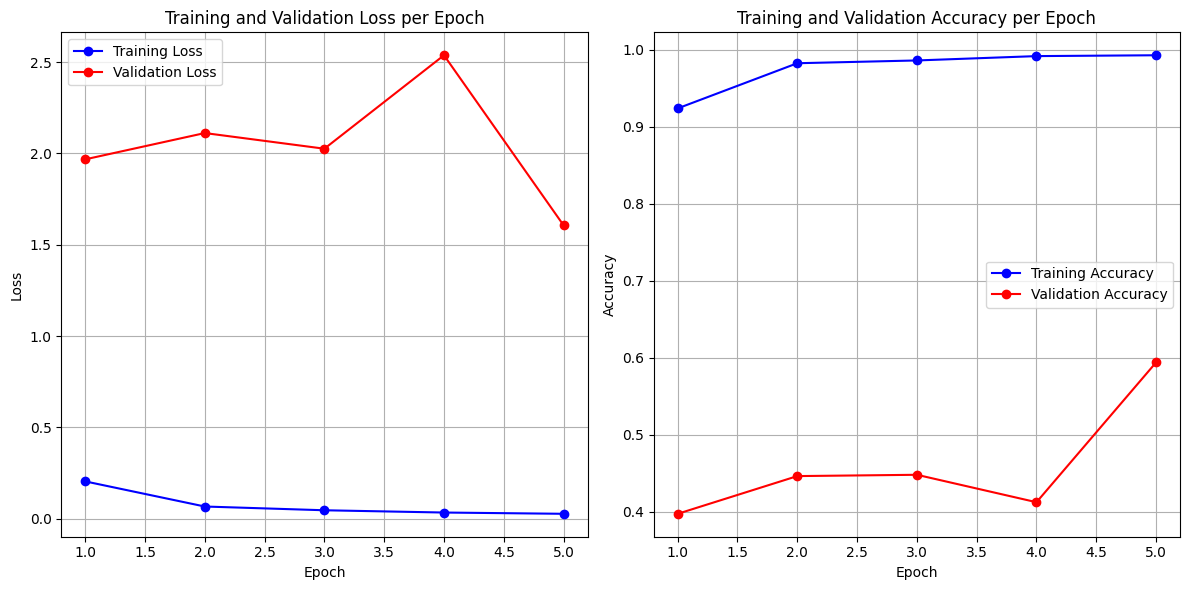

In [19]:
# Model Training

# Define variables for early stopping
best_val_loss = np.Inf  # Initialize with a very large value
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter to track epochs without improvement

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)
        # print(predicted_labels)
        # print(batch_labels)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate accuracy for the training epoch
    accuracy_train = correct_predictions / total_samples
    accuracy_per_epoch['train'].append(accuracy_train)

    # Calculate average loss for the training epoch
    average_loss_train = total_loss / len(dataloader_train)
    loss_per_epoch['train'].append(average_loss_train)
   
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch_val in tqdm(dataloader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            batch_input_ids, batch_attention_masks, batch_labels = batch_val
            batch_input_ids, batch_attention_masks, batch_labels = (
                batch_input_ids.to(device),
                batch_attention_masks.to(device),
                batch_labels.to(device),
            )
            outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels,
                )

            loss_val = outputs.loss
            total_loss_val += loss_val.item()

            _, predicted_labels_val = torch.max(outputs.logits, 1)
            correct_predictions_val += (predicted_labels_val == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)

    # Calculate accuracy for the validation epoch
    accuracy_val = correct_predictions_val / total_samples_val
    accuracy_per_epoch['val'].append(accuracy_val)

    # Calculate average loss for the validation epoch
    average_loss_val = total_loss_val / len(dataloader_val)
    loss_per_epoch['val'].append(average_loss_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_loss_val}, Validation Accuracy: {accuracy_val}")
    
    # Early stopping logic
    if average_loss_val < best_val_loss:
        best_val_loss = average_loss_val
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1  # Increment counter if validation loss does not improve

    if counter >= patience:
        print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
        break  # Exit training loop if early stopping condition is met

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.)
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModelForSequenceClassification.from_pretrained later.
model.save_pretrained("./model/BERTweet model_v2")
tokenizer.save_pretrained("./model/BERTweet model_v2")

# Plot the loss values
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch['train'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), loss_per_epoch['val'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['train'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['val'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# trained model
# lr = 5e-5
# batch size = 32
# epoch = 5
# total training time = 331 mins
# optimizer = AdamW

# Load the BERTweet tokenizer and model for sequence classification
model_path = "./model/BERTweet model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)


BERTweet:
                     precision    recall  f1-score   support

Offensive Languages       0.98      0.58      0.73      3842
        Hate Speech       0.13      0.85      0.23       282

           accuracy                           0.60      4124
          macro avg       0.56      0.72      0.48      4124
       weighted avg       0.92      0.60      0.70      4124



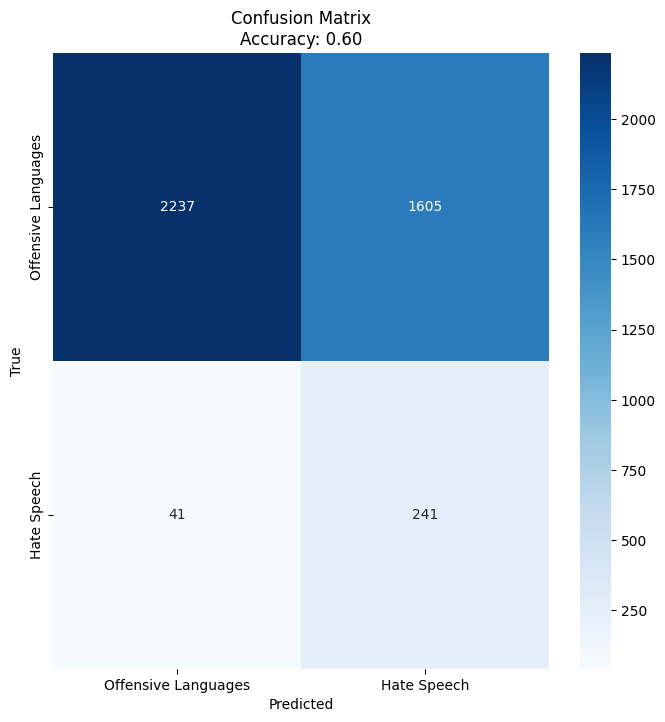

In [20]:
label_dict = {'Offensive Languages': 0, 'Hate Speech': 1}

# Evaluation loop
model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Evaluate the model
print("BERTweet:")
print(classification_report(y_test, all_preds, target_names=label_dict.keys()))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, all_preds)
accuracy_bertweet = accuracy_score(y_test, all_preds)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
# sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_bertweet:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
